In [1]:
import numpy as np
import time
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
x_height, x_width = [28, 28]
num_channels = 1
num_classes = 10
latent_size = 100
labeled_rate = 0.1

log_path = './SSL_GAN_log.csv'
model_path ='./SSL_GAN_model.ckpt'

In [3]:
def normalize(x):
    # normalize data
    x = (x - 127.5) / 127.5
    return x.reshape((-1, x_height, x_width, 1))

In [4]:
 def get_data():
    # MNIST data
    from tensorflow.examples.tutorials.mnist import input_data
    mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)
    #mnist_data = input_data.read_data_sets('mnist_data', one_hot = True)
    return mnist_data

In [5]:
def D(x, dropout_rate, is_training, reuse = True, print_summary = True):
    # discriminator (x -> n + 1 class)

    with tf.variable_scope('Discriminator', reuse = reuse) as scope:
        # layer1 - do not use Batch Normalization on the first layer of Discriminator
        conv1 = tf.layers.conv2d(x, 32, [5, 5],
                                 strides = [2, 2],
                                 padding = 'same')
        lrelu1 = tf.maximum(0.2 * conv1, conv1) #leaky relu
        dropout1 = tf.layers.dropout(lrelu1, dropout_rate)

        # layer2
        conv2 = tf.layers.conv2d(dropout1, 64, [3, 3],
                                 strides = [2, 2],
                                 padding = 'same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training = is_training)
        lrelu2 = tf.maximum(0.2 * batch_norm2, batch_norm2)

        # layer3
        conv3 = tf.layers.conv2d(lrelu2, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training = is_training)
        lrelu3 = tf.maximum(0.2 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, dropout_rate)

        # layer 4
        conv4 = tf.layers.conv2d(dropout3, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        # do not use batch_normalization on this layer - next layer, "flatten5",
        # will be used for "Feature Matching"
        lrelu4 = tf.maximum(0.2 * conv4, conv4)

        # layer 5
        flatten_length = lrelu4.get_shape().as_list()[1] * \
                         lrelu4.get_shape().as_list()[2] * lrelu4.get_shape().as_list()[3]
        flatten5 = tf.reshape(lrelu4, (-1, flatten_length)) # used for "Feature Matching" 
        fc5 = tf.layers.dense(flatten5, (num_classes))
        output = tf.nn.softmax(fc5)

        assert output.get_shape()[1:] == [num_classes]

        if print_summary:
            print('Discriminator summary:\n x: %s\n' \
                  ' D1: %s\n D2: %s\n D3: %s\n D4: %s\n' %(x.get_shape(), 
                                                           dropout1.get_shape(),
                                                           lrelu2.get_shape(), 
                                                           dropout3.get_shape(),
                                                           lrelu4.get_shape()))
        return flatten5, fc5, output

In [6]:
def G(z, is_training, reuse = False, print_summary = False):
    # generator (z -> x)

    with tf.variable_scope('Generator', reuse = reuse) as scope:
        # layer 0
        z_reshaped = tf.reshape(z, [-1, 1, 1, latent_size])

        # layer 1
        deconv1 = tf.layers.conv2d_transpose(z_reshaped,
                                             filters = latent_size,
                                             kernel_size = [2, 2],
                                             strides = [1, 1],
                                             padding = 'valid')
        batch_norm1 = tf.layers.batch_normalization(deconv1, training = is_training)
        relu1 = tf.nn.relu(batch_norm1)

        # layer 2
        deconv2 = tf.layers.conv2d_transpose(relu1,
                                             filters = 64,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'valid')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training = is_training)
        relu2 = tf.nn.relu(batch_norm2)

        # layer 3
        deconv3 = tf.layers.conv2d_transpose(relu2,
                                             filters = 32,
                                             kernel_size = [4, 4],
                                             strides = [2, 2],
                                             padding = 'valid')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training = is_training)
        relu3 = tf.nn.relu(batch_norm3)

        # layer 4 - do not use Batch Normalization on the last layer of Generator
        deconv4 = tf.layers.conv2d_transpose(relu3,
                                             filters = num_channels,
                                             kernel_size = [6, 6],
                                             strides = [2, 2],
                                             padding = 'valid')
        tanh4 = tf.tanh(deconv4)

        assert tanh4.get_shape()[1:] == [x_height, x_width, num_channels]
        if print_summary:
            print('Generator summary:\n z: %s\n' \
                  ' G0: %s\n G1: %s\n G2: %s\n G3: %s\n G4: %s\n' %(z.get_shape(),
                                                                    z_reshaped.get_shape(),
                                                                    relu1.get_shape(),
                                                                    relu2.get_shape(),
                                                                    relu3.get_shape(),
                                                                    tanh4.get_shape()))
        return tanh4

In [7]:
def build_model(x_real, z, label, dropout_rate, is_training, print_summary = False):
    # build model
    D_real_features, D_real_logit, D_real_prob = D(x_real, dropout_rate, is_training,
                                                   reuse = False, print_summary = print_summary)
    x_fake = G(z, is_training, reuse = False, print_summary = print_summary)
    D_fake_features, D_fake_logit, D_fake_prob = D(x_fake, dropout_rate, is_training,
                                                   reuse = True, print_summary = print_summary)

    return D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, x_fake

In [8]:
def prepare_labels(label):
    # add extra label for fake data
    extended_label = tf.concat([label, tf.zeros([tf.shape(label)[0], 1])], axis = 1)

    return extended_label

In [19]:
def loss_accuracy(D_real_features, D_real_logit, D_real_prob, D_fake_features,
                  D_fake_logit, D_fake_prob, extended_label, labeled_mask):
    epsilon = 1e-8 # used to avoid NAN loss
    # *** Discriminator loss ***
    # supervised loss
    # which class the real data belongs to
    tmp = tf.nn.softmax_cross_entropy_with_logits(logits = D_real_logit,
                                                  labels = extended_label)
    
    D_L_supervised = tf.reduce_sum(labeled_mask * tmp) / tf.reduce_sum(labeled_mask) # to ignore
                                                                                     # unlabeled
                                                                                     # data

    # unsupervised loss
    # data is real
    prob_real_be_real = 1 - D_real_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_real_be_real)
    D_L_unsupervised1 = -1 * tf.reduce_mean(tmp_log)

    # data is fake
    prob_fake_be_fake = D_fake_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_fake_be_fake)
    D_L_unsupervised2 = -1 * tf.reduce_mean(tmp_log)

    D_L = D_L_supervised + epsilon#+ D_L_unsupervised1 + D_L_unsupervised2

    # *** Generator loss ***
    # fake data is mistaken to be real
    prob_fake_be_real = 1 - D_fake_prob[:, -1] + epsilon
    tmp_log =  tf.log(prob_fake_be_real)
    G_L1 = -1 * tf.reduce_mean(tmp_log)

    # Feature Maching
    tmp1 = tf.reduce_mean(D_real_features, axis = 0)
    tmp2 = tf.reduce_mean(D_fake_features, axis = 0)
    G_L2 = tf.reduce_mean(tf.square(tmp1 - tmp2))

    G_L = G_L1 + G_L2

    # accuracy
    correct_prediction = tf.equal(tf.argmax(D_real_prob[:, :-1], 1), tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return D_L_supervised, D_L_unsupervised1, D_L_unsupervised2, D_L, G_L, accuracy
    

In [20]:
def optimizer(D_Loss, G_Loss, D_learning_rate, G_learning_rate):
    # D and G optimizer
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]

        D_optimizer = tf.train.AdamOptimizer(D_learning_rate).minimize(D_Loss, var_list = D_vars)
        G_optimizer = tf.train.AdamOptimizer(G_learning_rate).minimize(G_Loss, var_list = G_vars)
        return D_optimizer, G_optimizer

In [21]:
def plot_fake_data(data, grid_size = [5, 5]):
    # visualize some data generated by G
    _, axes = plt.subplots(figsize = grid_size, nrows = grid_size[0], ncols = grid_size[1],
                           sharey = True, sharex = True)

    size = grid_size[0] * grid_size[1]
    index = np.int_(np.random.uniform(0, data.shape[0], size = (size)))
    figs = data[index].reshape(-1, x_height, x_width)

    for idx, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(figs[idx], cmap = 'gray')
    plt.tight_layout()
    plt.show()

In [22]:
def save_model_on_imporvemnet(file_path, sess, cv_acc, cv_accs):
  #  # save model when there is improvemnet in cv_acc value
    if cv_accs == [] or cv_acc > np.max(cv_accs):
        saver = tf.train.Saver(max_to_keep = 1)
        saver.save(sess, file_path)
        print('Model saved')
    print('')

In [23]:
def get_labled_mask(labeled_rate, batch_size):
    # get labeled mask to mask some data unlabeled
    labeled_mask = np.zeros([batch_size], dtype = np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    #np.random.shuffle(labeled_mask)

    return labeled_mask

In [24]:
def log_loss_acc(file_path, epoch, train_loss_D, train_loss_G, train_Acc,
                 cv_loss_D, cv_loss_G, cv_Acc, log_mode = 'a'):
    # log train and cv losses as well as accuracy
    mode = log_mode if epoch == 0 else 'a'

    with open(file_path, mode) as f:
        if mode == 'w':
            header = 'epoch, train_loss_D, train_loss_G,' \
                     'train_Acc, cv_loss_D, cv_loss_G, cv_Acc\n'
            f.write(header)

        line = '%d, %f, %f, %f, %f, %f, %f\n' %(epoch, train_loss_D, train_loss_G, train_Acc,
                                                cv_loss_D, cv_loss_G, cv_Acc)
        f.write(line)

In [25]:
def train_SSL_GAN(batch_size, epochs):
    # train Semi-Supervised Learning GAN
    train_D_losses, train_G_losses, train_Accs = [], [], []
    cv_D_losses, cv_G_losses, cv_Accs = [], [], []

    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, name = 'x', shape = [None, x_height, x_width, num_channels])
    label = tf.placeholder(tf.float32, name = 'label', shape = [None, num_classes])
    labeled_mask = tf.placeholder(tf.float32, name = 'labeled_mask', shape = [None])
    z = tf.placeholder(tf.float32, name = 'z', shape = [None, latent_size])
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    G_learning_rate = tf.placeholder(tf.float32, name = 'G_learning_rate')
    D_learning_rate = tf.placeholder(tf.float32, name = 'D_learning_rate')

    model = build_model(x, z, label, dropout_rate, is_training, print_summary = True)
    D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, fake_data = model
    extended_label = label#prepare_labels(label)
    loss_acc  = loss_accuracy(D_real_features, D_real_logit, D_real_prob,
                              D_fake_features, D_fake_logit, D_fake_prob,
                              extended_label, labeled_mask)
    _, _, _, D_L, G_L, accuracy = loss_acc
    D_optimizer, G_optimizer = optimizer(D_L, G_L, G_learning_rate, D_learning_rate)

    print('training....')

    with tf.Session() as sess:       
        sess.run(tf.global_variables_initializer())
        mnist_set = get_data()

        for epoch in range(epochs):
            t_total = 0
            for iter in range(int(mnist_set.train.images.shape[0] / batch_size) + 1):
                t_start = time.time()
                batch = mnist_set.train.next_batch(batch_size, shuffle = False)
                batch_z = np.random.uniform(-1.0, 1.0, size = (batch_size, latent_size))
                mask = get_labled_mask(labeled_rate, batch_size)
                train_feed_dictionary = {x:  normalize(batch[0]),
                                         z: batch_z,
                                         label: batch[1],
                                         labeled_mask: mask,
                                         dropout_rate: 0.5,
                                         G_learning_rate: 1e-5,
                                         D_learning_rate: 1e-5,
                                         is_training: True}

                D_optimizer.run(feed_dict = train_feed_dictionary)
                #G_optimizer.run(feed_dict = train_feed_dictionary)

                train_D_loss = D_L.eval(feed_dict = train_feed_dictionary)
                train_G_loss = 0#G_L.eval(feed_dict = train_feed_dictionary)
                train_accuracy = accuracy.eval(feed_dict = train_feed_dictionary)
                t_total += (time.time() - t_start)

                print('epoch: %d, time: %f | train_G_Loss: %f, ' \
                      'train_D_loss: %f, train_acc: %f' %(epoch, t_total,
                                                          train_G_loss, train_D_loss,
                                                          train_accuracy), end = '\r')
            train_D_losses.append(train_D_loss)
            #train_G_losses.append(train_G_loss)
            train_Accs.append(train_accuracy)

            # Cross-Validation
            cv_size = mnist_set.test.labels.shape[0]
            #cv_batch_z = np.random.uniform(-1.0, 1.0, size = (cv_size, latent_size))
            mask = get_labled_mask(1, cv_size)
            cv_feed_dictionary = {x: normalize(mnist_set.test.images),
                                  z: cv_batch_z,
                                  label: mnist_set.test.labels,
                                  labeled_mask: mask,
                                  dropout_rate: 0.0,
                                  is_training: False}

            cv_D_loss = D_L.eval(feed_dict = cv_feed_dictionary)
            cv_G_loss = 0#G_L.eval(feed_dict = cv_feed_dictionary)
            cv_accuracy = accuracy.eval(feed_dict = cv_feed_dictionary)

            log_loss_acc(log_path, epoch, train_D_loss, train_G_loss, train_accuracy,
                         cv_D_loss, cv_G_loss, cv_accuracy, log_mode = 'w')
            print('\ncv_G_Loss: %f, cv_D_loss: %f, cv_acc: %f' %(cv_G_loss,
                                                                 cv_D_loss,
                                                                 cv_accuracy))
            save_model_on_imporvemnet(model_path, sess, cv_accuracy, cv_Accs)
            cv_D_losses.append(cv_D_loss)
            cv_G_losses.append(cv_G_loss)
            cv_Accs.append(cv_accuracy)

            #if epoch % 10 == 0:
            #    fakes = fake_data.eval(feed_dict = cv_feed_dictionary)
            #    plot_fake_data(fakes, [5, 5])

    return train_D_losses, train_G_losses, train_Accs, cv_D_losses, cv_G_losses, cv_Accs

In [26]:
loss_acc = train_SSL_GAN(2, 151)

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 7, 7, 64)
 D3: (?, 4, 4, 128)
 D4: (?, 2, 2, 128)

Generator summary:
 z: (?, 100)
 G0: (?, 1, 1, 100)
 G1: (?, 2, 2, 100)
 G2: (?, 5, 5, 64)
 G3: (?, 12, 12, 32)
 G4: (?, 28, 28, 1)

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 7, 7, 64)
 D3: (?, 4, 4, 128)
 D4: (?, 2, 2, 128)

training....
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


KeyboardInterrupt: 

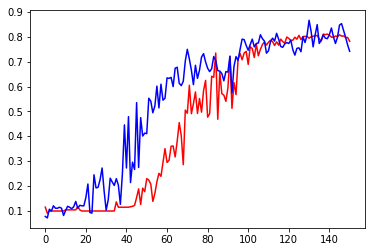

In [21]:
import matplotlib.pyplot as plt
train_acc = loss_acc[2]
test_acc = loss_acc[5]
plt.plot(test_acc, 'r', label='test accuracy')
plt.plot(train_acc, 'b', label='train accuracy')
plt.show()